# Clustering Scifi Stories
I scraped these from Tor.com

In [ ]:
import scrapy
import scrapy.crawler
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess({'AUTOTHROTTLE_ENABLED': True, # or download delay
                          'HTTPCACHE_ENABLED': True, # remove for final scrape to get live data
                          'ROBOTSTXT_OBEY': True, 
                          'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
                          'FEED_URI': 'sf_stories.csv',
                          'FEED_FORMAT': 'csv',
                          'FEED_EXPORT_ENCODING': '"utf-8"'})
class TorSpider(scrapy.Spider):
    name = 'tors'
    base_url = 'https://www.tor.com/category/all-fiction/original-fiction/page/{}'
    page = 1
    start_urls = [base_url.format(1)]
    def parse(self, response):
        # example //*[@id="post-497584"]/header/h2/a
        for item in response.xpath("//*[starts-with(@id,'post-')]/header/h2/a/@href"):
            item_url = response.urljoin(item.extract())
            yield scrapy.Request(item_url, callback=self.story)
        #if response.xpath("//*[@id='infinite-handle']/span/button").extract():
        page = response.request.url[63:64] if response.request.url[63:65].find('/') else response.request.url[63:65]
        if page == "":
            page = 1 
        page = int(page)
        page += 1
        yield scrapy.Request(self.base_url.format(page))
                                    
    def story(self, response):
        # example //*[@id="post-497584"]/div
        # //*[@id="post-497584"]/header/h2/a
        # //*[@id="post-497584"]/div
        yield {'Title': response.xpath("//*[starts-with(@id,'post-')]/header/h2/a/text()").extract(),
               'Author': response.xpath("//*[starts-with(@id,'post-')]/header/a/text()").extract(),
               #//*[@id="post-497584"]/div/p[7]
               'Body': response.xpath("//*[starts-with(@id,'post-')]/div/p/text()").extract()}


process.crawl(TorSpider)
process.start()

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

from nltk.corpus import stopwords as nltkstopwords
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')

from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [76]:
stories_df = pd.read_csv('sf_stories.csv')

In [77]:
stories_df.head()

,Title,Author,Body
0,One/Zero,Kathleen Ann Goonan,"In war-torn Kurdistan, a group of traumatized ..."
1,Blue Morphos in the Garden,Lis Mitchell,When Vivian and her daughter witness the famil...
2,Painless,Rich Larson,A man who can’t feel pain has been bioengineer...
3,Mama Bruise,Jonathan Carroll,A couple is concerned when their dog behaves i...
4,"The Mongolian Wizard Stories,Murder in the Spo...",Michael Swanwick,A brand new story in the Mongolian Wizard univ...


In [78]:
stories_df["Author"].value_counts().value_counts()

1    102
2     14
3      5
4      1
Name: Author, dtype: int64

In [101]:
stopwords = nltkstopwords.words('english')
punct = set(string.punctuation)
lem = WordNetLemmatizer()
def text_cleaner(text):
    text = text.lower()
    cleantext1 = " ".join(word for word in text.split() if word not in punct)
    cleantext2 = " ".join(word for word in cleantext1.split() if word not in stopwords)
    
    def lem_and_token(txt):
        '''tokenizes, and lemmatizes based on word position'''
        return [lem.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lem.lemmatize(i) \
                 for i, j in pos_tag(word_tokenize(txt))]

    cleantext3 = lem_and_token(cleantext2)
    return cleantext3

In [102]:
stories_df["tokenized_words"] = stories_df.Body.apply(text_cleaner)

In [103]:
stories_df.head()

,Title,Author,Body,tokenzied_words,tokenized_words
0,One/Zero,Kathleen Ann Goonan,"In war-torn Kurdistan, a group of traumatized ...","war-torn kurdistan , group traumatize orphan g...","[war-torn, kurdistan, ,, group, traumatize, or..."
1,Blue Morphos in the Garden,Lis Mitchell,When Vivian and her daughter witness the famil...,vivian daughter witness family matriarch die w...,"[vivian, daughter, witness, family, matriarch,..."
2,Painless,Rich Larson,A man who can’t feel pain has been bioengineer...,man can ’ t feel pain bioengineered kill machi...,"[man, can, ’, t, feel, pain, bioengineered, ki..."
3,Mama Bruise,Jonathan Carroll,A couple is concerned when their dog behaves i...,couple concerned dog behaves increasingly biza...,"[couple, concerned, dog, behaves, increasingly..."
4,"The Mongolian Wizard Stories,Murder in the Spo...",Michael Swanwick,A brand new story in the Mongolian Wizard univ...,"brand new story mongolian wizard universe. , ,...","[brand, new, story, mongolian, wizard, univers..."


In [121]:
# term frequency-inverse document frequncy
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(stories_df.tokenized_words.apply(lambda x: " ".join(x)))

In [113]:
# k-means++ givens evenly distributed starting pts
kmean = KMeans(n_clusters=5, init='k-means++', max_iter=200, n_init=100)
kmean.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=5, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

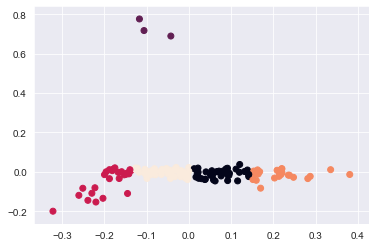

In [127]:
X_tfidf_norm = normalize(X_tfidf.toarray())
X_tfidf_pca = PCA(2).fit_transform(X_tfidf_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=5, init='k-means++', max_iter=200, n_init=100).fit_predict(X_tfidf_pca)

sns.set_style('darkgrid')
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=y_pred)
plt.show();